In [1]:
from scipy.signal import find_peaks
from data import readsegy, whightening, stalta, generate_tt, gen_fm_grid
from config import read_config_file
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from config import read_config_file, read_station_file
from stackCU import stack_CUDA
from stackCU import show_result as show_result_ssa
from stackCU import calc_position as calc_position_ssa
from stackMechCU import stack_mech_CUDA, gen_intensity_CUDA, checkData
from stackMechCU import show_result as show_result_jssa
from stackMechCU import calc_position as calc_position_jssa
from draw import draw_maxbrightness, draw_beachball
from model_bfnet import StrikeDipRakeNet
import torch
from utils import compute_moment_tensor_torch, plot_beachball
from obspy.imaging.beachball import aux_plane
from scipy.signal import butter, filtfilt


def preprocess_ssa(data_raw, sample_rate, w_l=25, w_h=60):
    data = np.copy(data_raw)
    for i in range(len(data)):
        # remove mean
        data[i] = data[i] - np.mean(data[i])
        # whightening
        data[i] = whightening(data[i], w_l-20, w_l, w_h, w_h+20, sample_rate)
        # STALTA
        data[i] = stalta(data[i], 5, 40)
    return np.asarray(data)


def seis_filter(data, order, lowcut, highcut, fs, filter_type='bandpass'):
    # normalize frequency
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design the filter
    if filter_type == 'bandpass':
        b, a = butter(order, [low, high], btype='bandpass')
    elif filter_type == 'bandstop':
        b, a = butter(order, [low, high], btype='bandstop')
    else:
        raise ValueError("filter_type must be 'bandpass' or 'bandstop'")

    # Apply zero-phase filtering using filtfilt
    filtered_data = filtfilt(b, a, data)

    return filtered_data


def preprocess_jssa(data_raw, sample_rate, w_l=25, w_h=60):
    data = np.copy(data_raw)
    for i in range(len(data)):
        # remove mean
        data[i] = data[i] - np.mean(data[i])
        # Filtering: 2nd-order 20-90 Hz band-pass filter，3rd-order 25-28 Hz band-stop filter
        data[i] = seis_filter(data[i], 3, 22, 60,
                              sample_rate, filter_type='bandpass')
        data[i] = seis_filter(data[i], 3, 30, 35,
                              sample_rate, filter_type='bandstop')
    return np.asarray(data)


def write_conf_file(conf, filename):
    with open(filename, 'w') as f:
        for key, value in conf.items():
            if isinstance(value, list):
                value_str = ' '.join(map(str, value))
            else:
                value_str = str(value)
            f.write(f"{key}={value_str}\n")


def show_max_vs_time(result, sample_rate):
    import numpy as np
    # Calculate the maximum value of xyz space at each time point
    # Take the maximum value over the first 3 dimensions (xyz) to get an array of shape (n_time,)
    max_values_per_time = np.max(result, axis=(0, 1, 2))
    n_time = max_values_per_time.shape[0]
    time_axis = np.arange(n_time) / sample_rate
    # Visualization: maximum value vs. time
    plt.figure(figsize=(10, 2), dpi=500)
    plt.plot(time_axis, max_values_per_time, color='cornflowerblue', linestyle='-', linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Max Brightness')
    plt.title('Maximum Brightness Over Time')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def find_peak_idx(signal, threshold, prominence=0, peak_pct=0.99):
    """
    Find the index of the left side first reaching xx% of peak value for each peak above a threshold.

    Parameters:
        signal: signal array
        threshold: peak threshold (peaks below this value are ignored)
        prominence: prominence of the peak (filter small fluctuations, default 0)

    Returns:
        peaks_info: list of dictionaries containing peak index, peak value, and left 90% threshold index
    """
    # Detect peaks and get key properties (including boundaries)
    peaks, props = find_peaks(
        signal,
        height=threshold,
        prominence=prominence,
    )
    peak_heights = props['peak_heights']  # Peak height
    peak_indices = peaks                  # Indices of peaks
    # Left boundary for the current peak (limits search range)
    left_bases = np.round(props['left_bases']).astype(int)

    peaks_info = []
    for idx, peak_idx in enumerate(peak_indices):
        peak_height = peak_heights[idx]
        ninety_pct_height = peak_height * peak_pct  # xx% peak threshold
        left_base = left_bases[idx]            # Left boundary of the current peak (within search range)

        # Search to the left: find the first index that reaches the 90% threshold within [left boundary, peak index]
        raise_idx = None
        # Search range: from left boundary to peak index (including peak itself, to avoid missing it)
        for i in range(left_base, peak_idx + 1):
            if signal[i] >= ninety_pct_height:
                raise_idx = i  # Record the first index that meets the threshold
                break
        else:
            # Extreme case: if no point meets the threshold, return the left boundary index
            raise_idx = left_base

        peaks_info.append({
            "peak_idx": peak_idx,               # Peak index
            "peak_height": peak_height,         # Peak height
            "raise_idx": raise_idx,   # Left side first reaching threshold index
        })

    return peaks_info

waveform file cnt: 1
conf_ssa: dict_values([0.04, 0.04, 40, 40, 20, -0.8, -0.8, -1.5, '0 0 0'])
conf_jssa: dict_values([0.025, 0.025, 8, 8, 8, -0.08, -0.08, -1.3, 15, 24, 7, 24, '0 0 0'])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26180\1110278939.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


model loaded

    [Processing 20230220_135030.sgy]
data shape: (120, 7501) sample_rate: 250
Calling CUDA function... params:
n_sta: 40, n_samples: 7501, n_grid: 32000
result shape: (40, 40, 20, 7501)
Found 1 peaks exceeding threshold 2.5


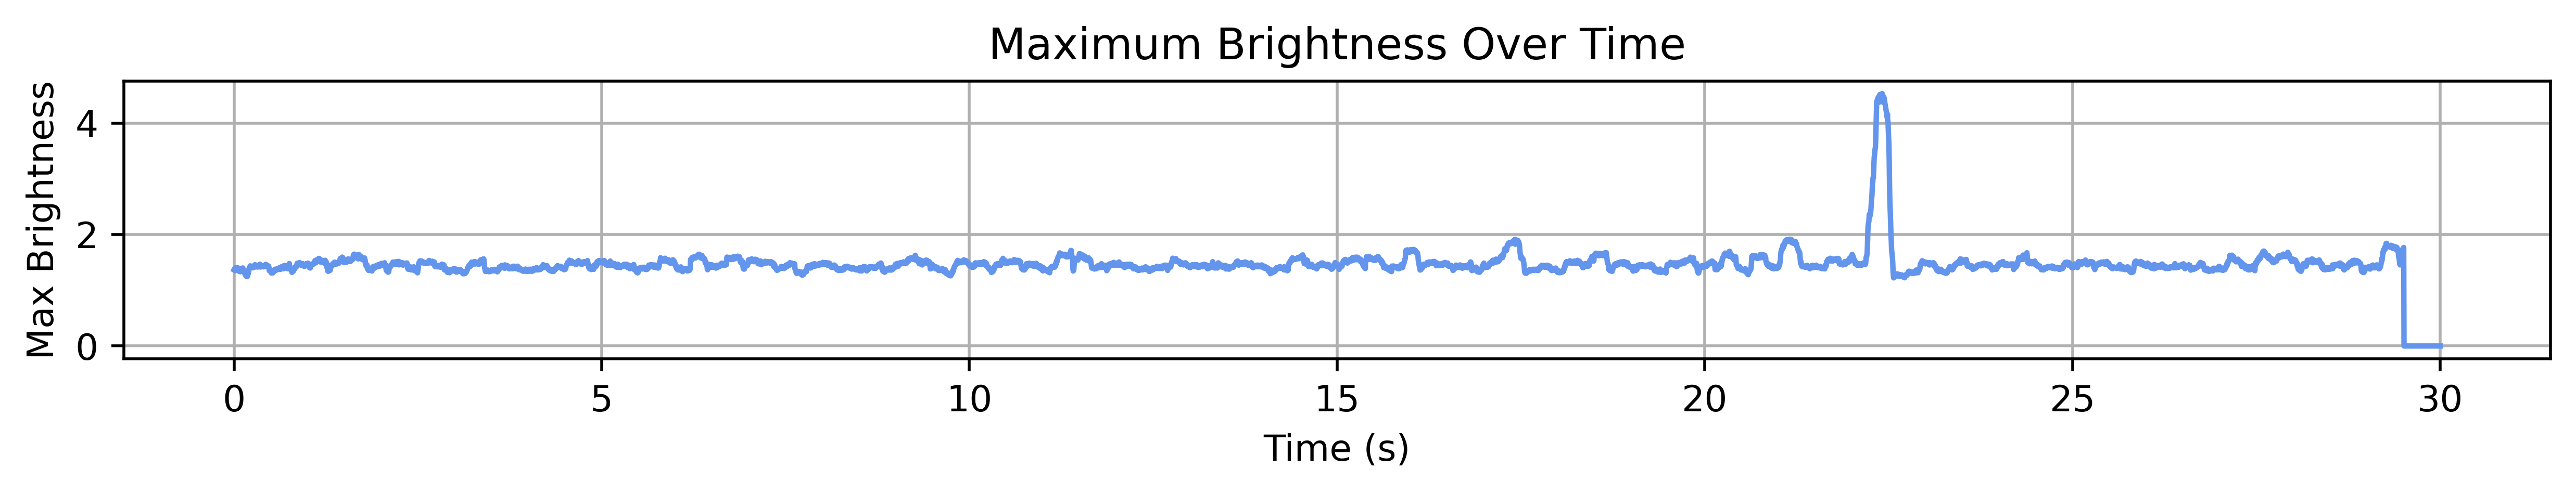

-- Peak at index 5603 (time 22.41s) with height 4.53, 
Event ID: 230220_135052412
SSA max index: [22 24  9 10], position: (0.08, 0.16, -1.14), time: 2023-02-20 13:50:52.412000


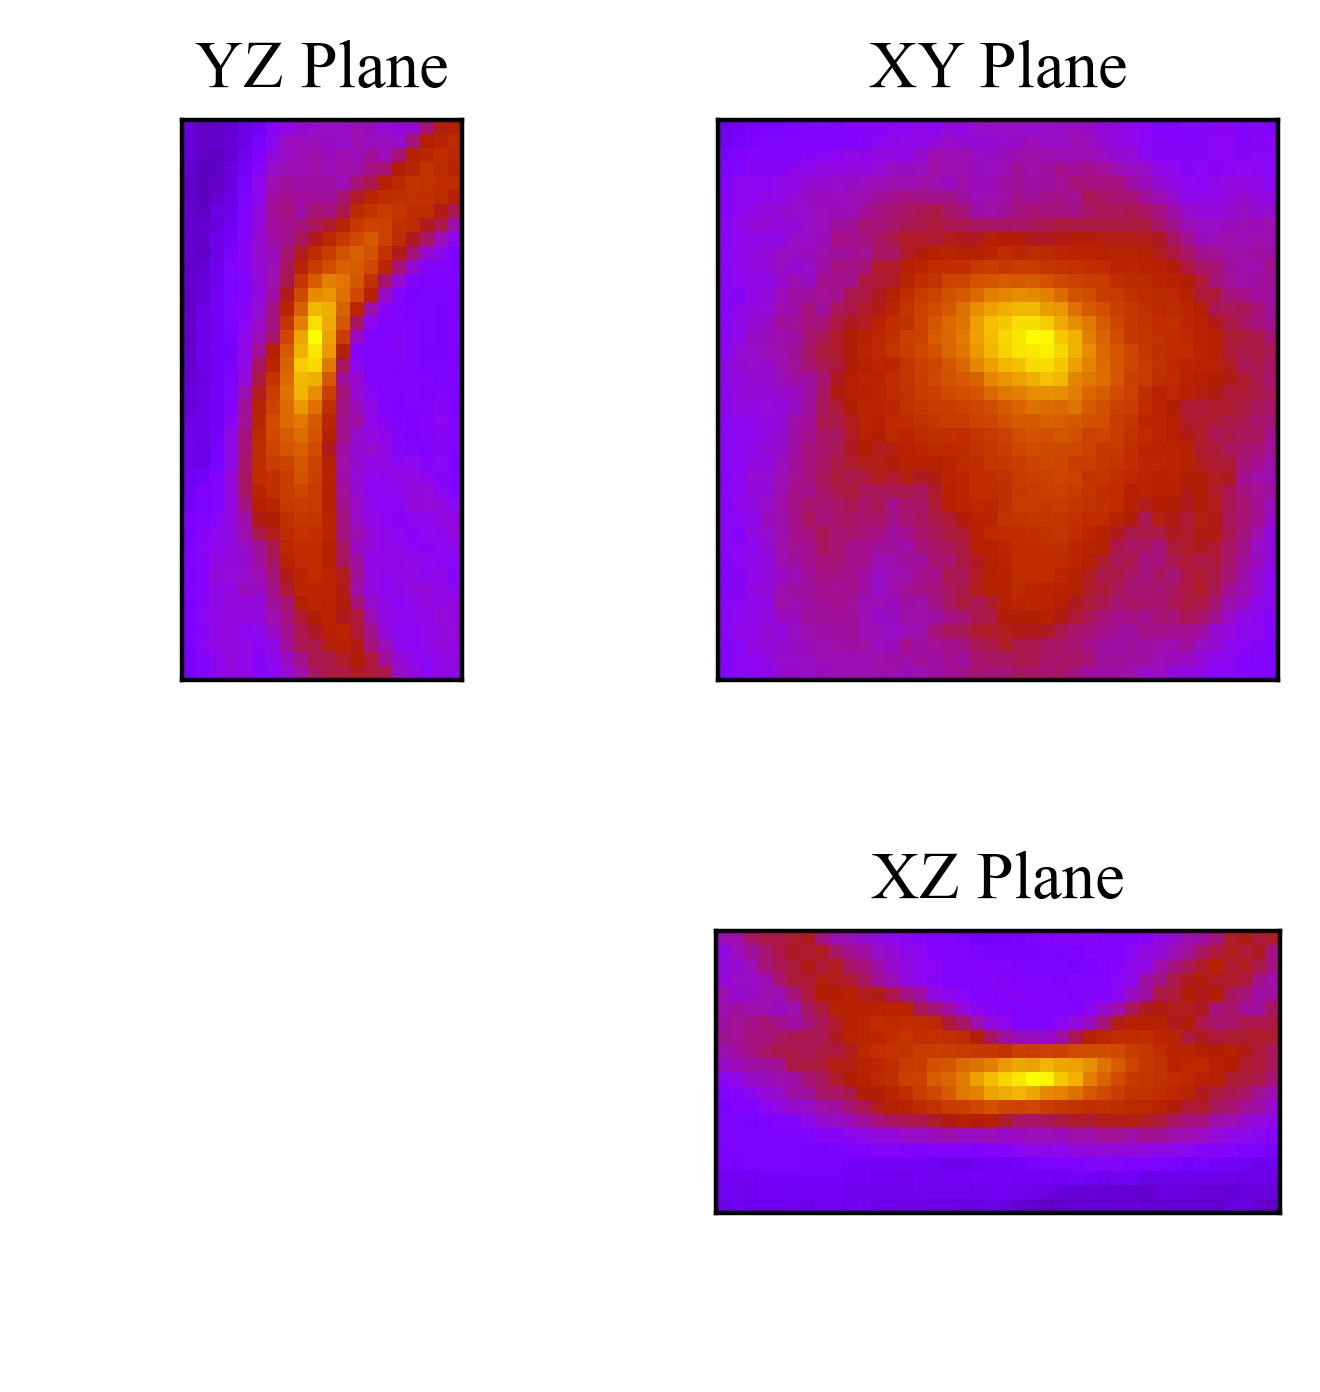

jssa max index: [   3    2    5 1229   53], (0.055, 0.11, -1.115, [105.  30. -90.]), time: 2023-02-20 13:50:52.424000


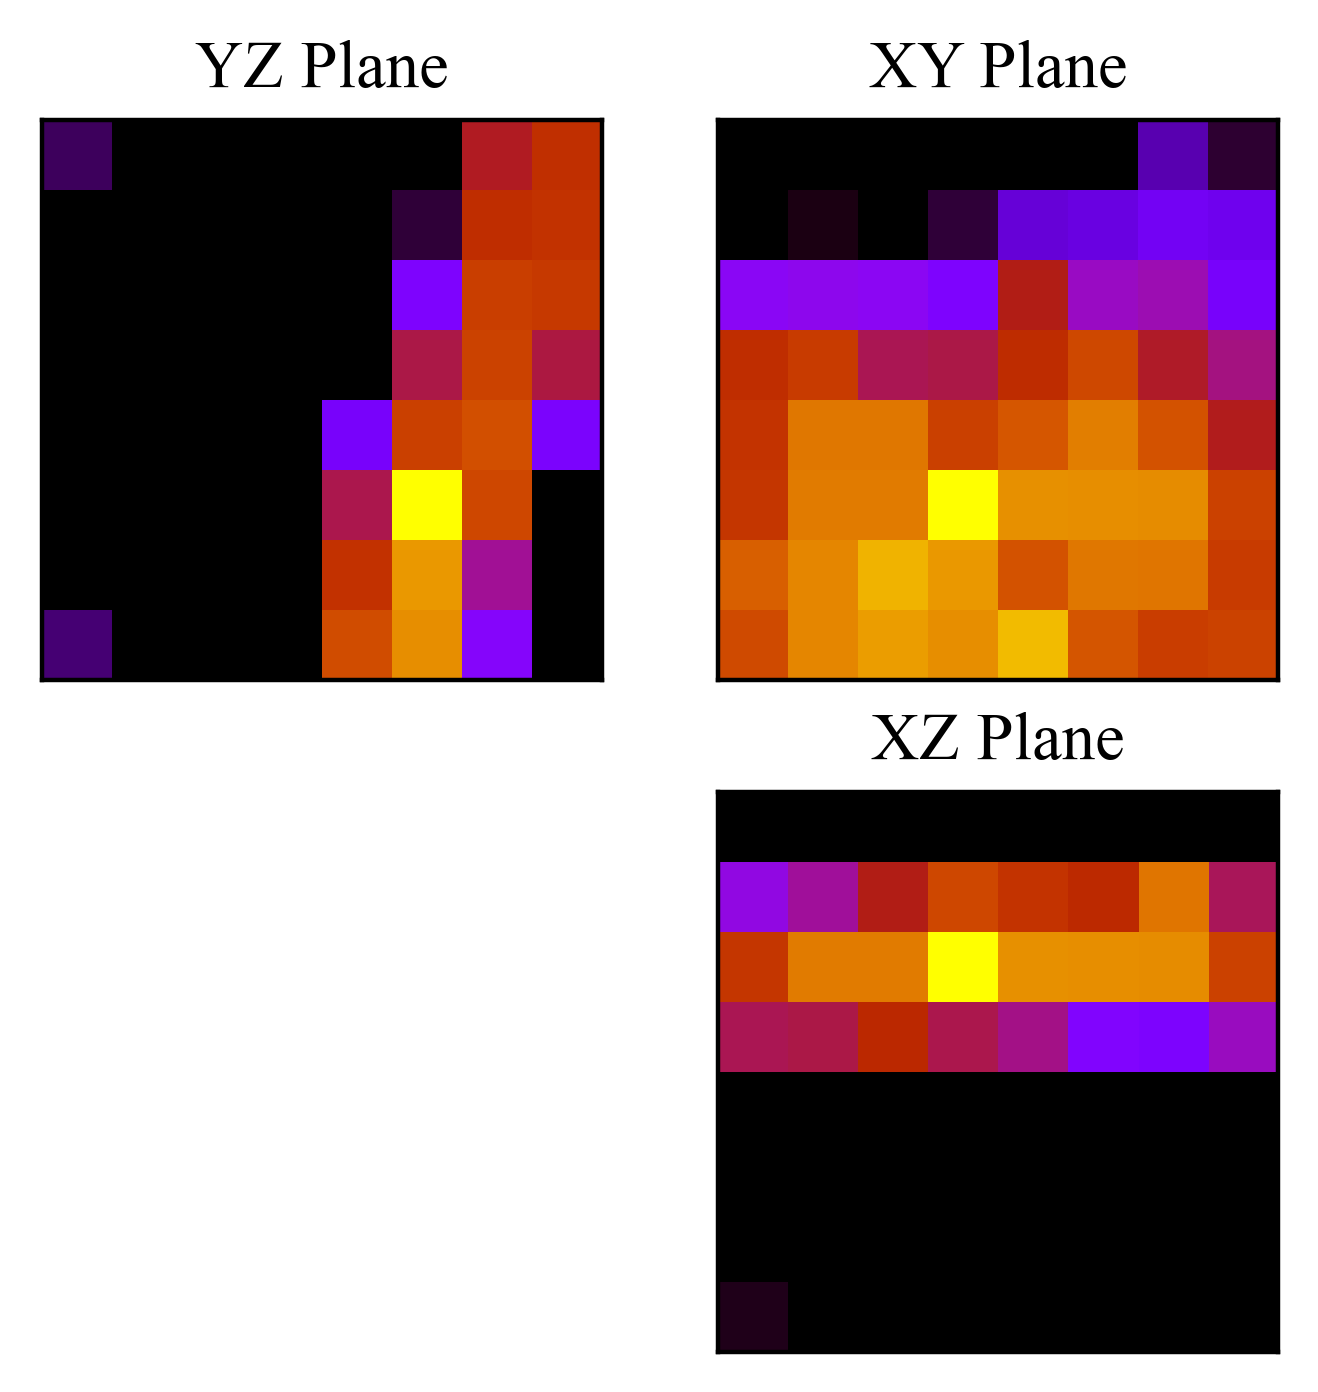

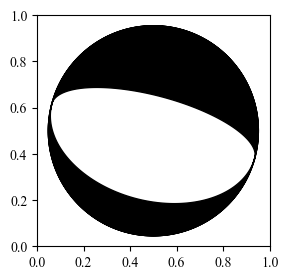

output mt: [-0.681  0.33   0.351 -0.274  0.651 -0.392]
sdr: 68.1, 77.5, 55.9
aux sdr: 320.3, 36.1, 158.4


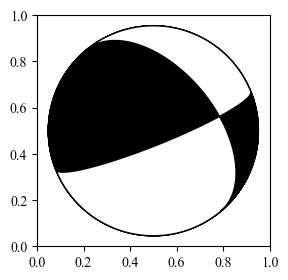

SSA results saved to ./result/results_ssa.txt
JSSA results saved to ./result/results_jssa.txt


In [2]:

folder_data = './waveform'
folder_conf = "./conf"
out_path = './result'
model_path = './model/bfnet_251104a.pt'
sta_fname = f'{folder_conf}/station_sorted.txt'
file_list = [f for f in os.listdir(folder_data) if f.endswith(".sgy")]
print("waveform file cnt:", len(file_list))
conf_ssa = read_config_file(f'{folder_conf}/conf_ssa.txt')
conf_jssa = read_config_file(f'{folder_conf}/conf_jssa.txt')
print("conf_ssa:", conf_ssa.values())
print("conf_jssa:", conf_jssa.values())
# Read station information
station = read_station_file(sta_fname, conf_ssa)
# Generate FM grid
fm_grid = gen_fm_grid(conf_jssa)
# tt_ssa is same, tt_jssa needs to be regenerated for each event
tt_ssa, _, _ = generate_tt(f'{folder_conf}/conf_ssa.txt',
                           f'{folder_conf}/vel.txt', sta_fname)
tt_max = np.max(tt_ssa)
peak_threshold = 2.5  # Event SSA threshold

# Instantiate the model and load parameters
shape = (8, 8, 8, 24, 7, 24)  # Input shape for the model
model = StrikeDipRakeNet(shape)
model.load_state_dict(torch.load(model_path))
model = model.to('cuda')
model.eval()
print("model loaded")


# Loop through each file for testing
results_ssa = []
results_jssa = []
results_bfnet = []
for file_name in file_list:
    print(f"\n    [Processing {file_name}]")
    file_path = os.path.join(folder_data, file_name)
    data, sta_ids, sample_rate, datetime_start = readsegy(file_path)
    print("data shape:", data.shape, "sample_rate:", sample_rate)
    n_time = data.shape[1]
    # whightening, stalta
    data_ssa = preprocess_ssa(data, sample_rate)

    # SSAstacking
    result_ssa = stack_CUDA(data_ssa, sample_rate, tt_ssa)
    # Check result type
    if type(result_ssa) == int and result_ssa == -1:
        print("stack_CUDA error")
        exit(0)
    result_ssa = result_ssa.reshape(
        conf_ssa['SearchSizeX'], conf_ssa['SearchSizeY'], conf_ssa['SearchSizeZ'],
        data.shape[1])
    print("result shape:", result_ssa.shape)

    max_value_per_time = np.max(result_ssa, axis=(0, 1, 2))

    # Find peaks in the result that exceed the threshold, multiple peaks may be present in one data segment
    time_axis = np.arange(n_time) / sample_rate
    peaks_info = find_peak_idx(
        max_value_per_time, peak_threshold, 0.5, 1)
    print(f"Found {len(peaks_info)} peaks exceeding threshold {peak_threshold}")
    # Plot max value vs. time
    show_max_vs_time(result_ssa, sample_rate)

    if len(peaks_info) == 0:
        print(
            f"No peaks found exceeding threshold {peak_threshold} in file {file_name}")
        continue

    # jssa data does not need stalta
    data_jssa = preprocess_jssa(data, sample_rate)
    # checkData(data_jssa)
    tt_max_sample = int(tt_max * sample_rate)
    # Process each peak
    for peak in peaks_info:
        peak_idx = peak['raise_idx']
        print(
            f"-- Peak at index {peak['peak_idx']} (time {time_axis[peak['peak_idx']]:.2f}s) with height {peak['peak_height']:.2f}, "
        )
        # Find max value and its position
        max_index = show_result_ssa(
            result_ssa[:, :, :, peak_idx-10:peak_idx+1], conf_ssa, sample_rate, False)
        # Record the result
        x, y, z, t = calc_position_ssa(conf_ssa, max_index, sample_rate)
        t = datetime_start + datetime.timedelta(seconds=t+(peak_idx-10)/sample_rate)
        # Event ID, formatted time with ms to avoid duplicate IDs
        evt_id = t.strftime("%y%m%d_%H%M%S%f")[:-3]
        results_ssa.append([x, y, z, t.timestamp()])
        print(f"Event ID: {evt_id}")
        print(
            f"SSA max index: {max_index}, position: ({x}, {y}, {z}), time: {t}")

        # SSA result visualization
        draw_maxbrightness(result_ssa[:, :, :, peak_idx], "SSA", save=False)

        # Update jssa configuration
        # print(f"Event {event_folder} max index: {max_index}, position: ({x}, {y}, {z}), time: {t}")
        conf_jssa['SearchOriginX'] = x - \
            conf_jssa['SearchSizeX']*conf_jssa['GridSpacingX']/2
        conf_jssa['SearchOriginY'] = y - \
            conf_jssa['SearchSizeY']*conf_jssa['GridSpacingX']/2
        conf_jssa['SearchOriginZ'] = z - \
            conf_jssa['SearchSizeZ']*conf_jssa['GridSpacingZ']/2
        # print("conf_jssa:", conf_jssa.values())
        write_conf_file(conf_jssa, f'{folder_conf}/conf_jssa_tmp.txt')

        # Generate jssa tt and intensity
        tt_jssa, _, _ = generate_tt(
            f'{folder_conf}/conf_jssa_tmp.txt', f'{folder_conf}/vel_jssa.txt', sta_fname)
        intensity = gen_intensity_CUDA(fm_grid, conf_jssa, station, 0.2)
        # Convert intensity to -1 and 1 based on its sign if donnot use amplitude
        # intensity = np.where(intensity > 0, 1, -1)

        # jssa stacking
        data_jssa_evt = data_jssa[:, peak_idx-50:peak_idx+tt_max_sample+30]
        result_jssa = stack_mech_CUDA(
            data_jssa_evt, sample_rate, tt_jssa, intensity)
        # Check result type
        if type(result_jssa) == int and result_jssa == -1:
            print("stack_mech_CUDA error")
            exit(0)

        result_jssa = result_jssa.reshape(
            conf_jssa['SearchSizeX'], conf_jssa['SearchSizeY'], conf_jssa['SearchSizeZ'],
            fm_grid.shape[0], data_jssa_evt.shape[1])
        max_index = show_result_jssa(
            result_jssa, conf_jssa, sample_rate, fm_grid, False)

        # Record the result
        x, y, z, fm, t = calc_position_jssa(conf_jssa, max_index, sample_rate)
        t = datetime_start + datetime.timedelta(seconds=t+(peak_idx-50)/sample_rate)
        fm = fm_grid[fm]
        results_jssa.append([x, y, z, *fm, t.timestamp()])
        print(f"jssa max index: {max_index}, ({x}, {y}, {z}, {fm}), time: {t}")
        # JSSA result visualization
        draw_maxbrightness(
            result_jssa[:, :, :, max_index[3], max_index[4]], "jSSA", save=False)
        draw_beachball(*fm)
        # fm brightness field visualization
        # draw_maxbrightness(
        #     result_jssa[max_index[0], max_index[1], max_index[2], :, max_index[4]].reshape((24,7,24)), "fm")
        # Neural network fm optimization
        x = torch.from_numpy(result_jssa[:, :, :, :, max_index[4]]).float()
        # Normalize
        min_val = x.min()
        max_val = x.max()
        x = (x - min_val) / (max_val - min_val + 1e-8)
        # Move data to GPU and add batch dimension
        x = x.to('cuda').reshape(1, 8, 8, 8, 24, 7, 24)
        output = model(x)
        output_mt = compute_moment_tensor_torch(output)
        output_mt = output_mt.cpu().detach().numpy()
        print(f"output mt: {output_mt[0].round(3)}")

        # Visualization
        output = output.cpu().detach().numpy()
        # Extract sin/cos pairs
        strike_sin = output[:, 0]
        strike_cos = output[:, 1]
        dip_sin = output[:, 2]
        dip_cos = output[:, 3]
        rake_sin = output[:, 4]
        rake_cos = output[:, 5]
        # Restore angles
        strike = np.atan2(strike_sin, strike_cos)
        dip = np.atan2(dip_sin, dip_cos)
        rake = np.atan2(rake_sin, rake_cos)
        dip = np.remainder(dip, torch.pi)  # Restrict dip to [0, pi]
        # Convert radians to degrees
        strike = np.rad2deg(strike)[0]
        dip = np.rad2deg(dip)[0]
        rake = np.rad2deg(rake)[0]
        s2, d2, r2 = aux_plane(strike, dip, rake)

        print(f"sdr: {strike:.1f}, {dip:.1f}, {rake:.1f}")
        print(f"aux sdr: {s2:.1f}, {d2:.1f}, {r2:.1f}")
        plot_beachball([strike, dip, rake])
        results_bfnet.append([strike, dip, rake, s2, d2, r2, t.timestamp()])

# Save results
ssa_results_file = f'{out_path}/results_ssa.txt'
jssa_results_file = f'{out_path}/results_jssa.txt'
bfnet_results_file = f'{out_path}/results_bfnet.txt'
with open(ssa_results_file, 'w') as f_ssa:
    f_ssa.write('X Y Z T\n')
    for res in results_ssa:
        f_ssa.write(' '.join([f'{v:.3f}' for v in res]) + '\n')
print(f"SSA results saved to {ssa_results_file}")        
with open(jssa_results_file, 'w') as f_jssa:
    f_jssa.write('X Y Z Strike Dip Rake T\n')
    for res in results_jssa:
        f_jssa.write(' '.join([f'{v:.3f}' for v in res]) + '\n')
print(f"JSSA results saved to {jssa_results_file}")
with open(bfnet_results_file, 'w') as f_bfnet:
    f_bfnet.write('Strike Dip Rake Strike2 Dip2 Rake2 T\n')
    for res in results_bfnet:
        f_bfnet.write(' '.join([f'{v:.3f}' for v in res]) + '\n')